In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

# read in datasets

In [3]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


month_ds_dict = {} 

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'./output/{month}_300s_43200ts_ds')

# Define constants

In [4]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
times = month_ds_dict[month].time.values

# Calculate the Energy Budget

In [61]:
month_ds_dict['January'].sel(co2_lev = .00076, model = 'rat')['T'][-1]

<xarray.DataArray 'T' (time: 151)>
array([245.266747, 245.344765, 245.417959, 245.487217, 245.552975, 245.615538,
       245.675157, 245.732036, 245.786349, 245.838277, 245.887954, 245.935512,
       245.981079, 246.024754, 246.066611, 246.106749, 246.145268, 246.18224 ,
       246.217742, 246.251839, 246.284618, 246.316138, 246.346445, 246.375594,
       246.403638, 246.430645, 246.456652, 246.481695, 246.505823, 246.529088,
       246.551506, 246.573116, 246.593946, 246.614036, 246.633422, 246.652118,
       246.670149, 246.687546, 246.70434 , 246.720551, 246.736201, 246.75132 ,
       246.765922, 246.780034, 246.793667, 246.80684 , 246.81957 , 246.831877,
       246.843777, 246.855285, 246.866413, 246.877175, 246.887585, 246.897652,
       246.907393, 246.916823, 246.92596 , 246.934803, 246.943359, 246.951643,
       246.95967 , 246.967437, 246.974966, 246.982255, 246.989312, 246.99614 ,
       247.002751, 247.009149, 247.015343, 247.021342, 247.027156, 247.032789,
       247.038242

In [53]:
month_ds_dict['January'].sel(co2_lev = 0.00076, model = 'rat')['LW_flux_down_clr'][-1][0].values

array(125.26694223)

In [54]:
month_ds_dict['January'].sel(co2_lev = 0, model = 'rat')['LW_flux_down_clr'][-1][0].values

array(95.56995165)

In [60]:
month_ds_dict['January'].sel(co2_lev = 0.00076, model = 'rat')['LW_flux_up_clr'][-1][-1].values

array(211.74648647)

In [59]:
month_ds_dict['January'].sel(co2_lev = 0, model = 'rat')['LW_flux_up_clr'][-1][-1].values

array(176.77986557)

In [28]:
time = times[-2]
co2 = CO2_conc1
timestep = 300
save_freq = 288

In [6]:
energy_budget_df = pd.DataFrame(index = pd.MultiIndex(levels=[months, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_mass','TOA_rad','SFC_rad','SFC_turb','ATM_adv','ATM_heat','energy_budget'])

In [7]:
for idx_month, month in enumerate(months):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        tmp_ds = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)
        #atmospheric mass
        energy_budget_df.loc[month, model]['ATM_mass'] = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)['heat_capacity'].sum().values #Pa
        
        #TOA Frad
        energy_budget_df.loc[month, model]['TOA_rad'] = (month_ds_dict[month].sel(model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][0] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2
        #Surface Frad
        energy_budget_df.loc[month, model]['SFC_rad'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
        #Surface Turbulence
        energy_budget_df.loc[month, model]['SFC_turb'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2
        
        #Atmospheric Advection
        energy_budget_df.loc[month, model]['ATM_adv'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['advection'][:-1].values * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).values.sum()
        
        #Atmospheric Heating
        energy_budget_df.loc[month, model]['ATM_heat'] = ((month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time+save_freq*timestep))['T'].values - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time))['T'].values)[:-1]/(save_freq*timestep) * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).sum().values
    
        
        energy_budget_df.loc[month, model]['energy_budget'] = (energy_budget_df.loc[month, model]['TOA_rad'] - 
                                                               energy_budget_df.loc[month, model]['SFC_rad'] +  
                                                               energy_budget_df.loc[month, model]['SFC_turb'] + 
                                                               energy_budget_df.loc[month, model]['ATM_adv'] - 
                                                               energy_budget_df.loc[month, model]['ATM_heat'])

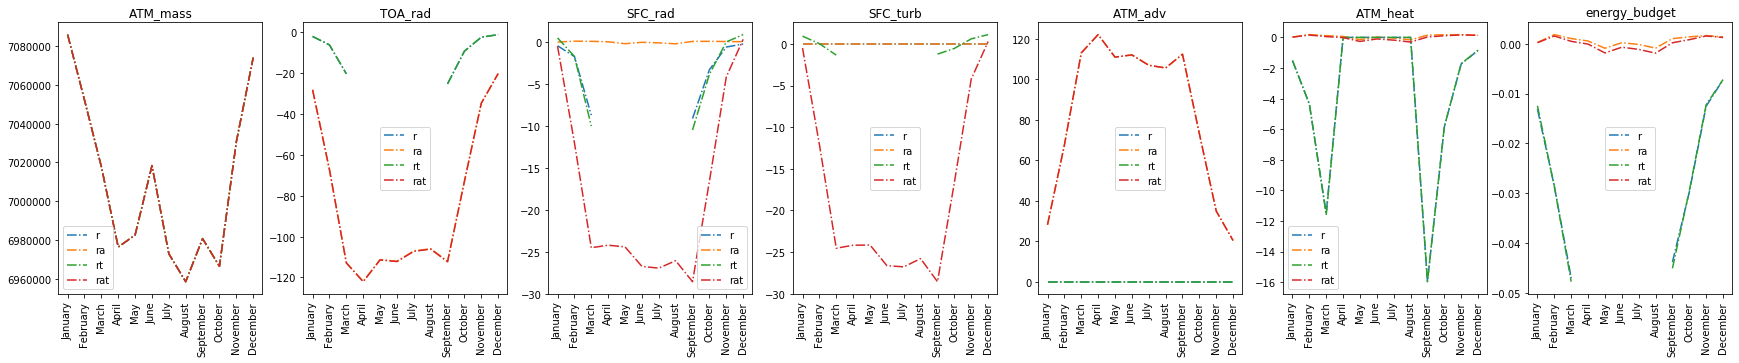

In [8]:
fig, axes = plt.subplots(1,7, figsize = (30, 5))
colors = cm.twilight(np.linspace(0,1,4))
for idx, result in enumerate(energy_budget_df.columns.values):
    ax = axes[idx]
    for model in ['r','ra','rt','rat']:
        ax.plot(energy_budget_df.query(f'model == "{model}"').index.get_level_values(0), energy_budget_df.query(f'model == "{model}"')[result], '-.', label = f'{model}')
    ax.legend()
    ax.set_xticklabels(labels = energy_budget_df.query(f'model == "{model}"').index.get_level_values(0),rotation = 90);
    ax.set_title(result)

In [9]:
energy_budget_df.query(f'model == "rat"')

,,ATM_mass,TOA_rad,SFC_rad,SFC_turb,ATM_adv,ATM_heat,energy_budget
month,model,,,,,,,
January,rat,7085831.885510202,-28.08455787432635,-0.4862045131324493,-0.4956630607170138,28.1139,0.019659645910804716,0.000194978
February,rat,7052158.135306121,-67.18784791831845,-11.994227741287872,-12.090952668863244,67.4418,0.15571190696320708,0.00153114
March,rat,7017852.7359183645,-112.882597440761,-24.499261479185876,-24.547267193556372,112.985,0.054025429428501186,0.000464058
April,rat,6976434.508775509,-122.07164973360835,-24.198048841597025,-24.18656371276193,122.048,-0.011851696466973984,-8.79168e-05
May,rat,6982615.819183674,-111.42126639579593,-24.39820689481543,-24.163055729868645,110.922,-0.26234086816218893,-0.00185711
June,rat,7018350.945306123,-112.21455303536507,-26.723737502525275,-26.64218700561814,112.032,-0.10006111691566441,-0.000714583
July,rat,6972969.376938776,-107.22970182839232,-26.9293498359278,-26.78385134971994,106.906,-0.1769723274461795,-0.00114604
August,rat,6958588.511224489,-106.12176390955095,-26.04560049402291,-25.79699297294757,105.569,-0.30187226332916084,-0.00190479
September,rat,6980780.343265304,-112.31340626607799,-28.546032066478503,-28.5678542213648,112.364,0.02871459545299291,0.000178576


# Temperature Structure (first timestep and final)

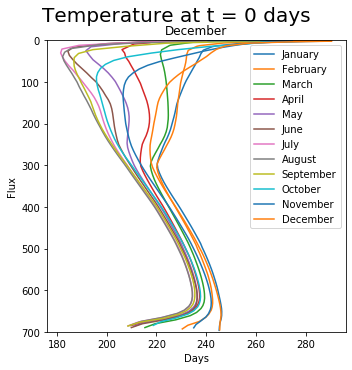

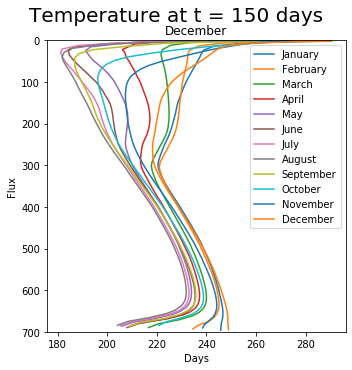

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
for month in months:
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = co2, time = times[0])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['lev_full']
    ax.plot(x, y, label = month)
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    ax.set_ylim(700,0)
    plt.tight_layout()
plt.legend()
plt.suptitle('Temperature at t = 0 days',fontsize = 20, y = 1.02);

fig, ax = plt.subplots(figsize=(5,5))
for month in months:
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = co2, time = times[-1])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['lev_full']
    ax.plot(x, y, label = month)
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    ax.set_ylim(700,0)
    plt.tight_layout()
plt.legend()
plt.suptitle('Temperature at t = 150 days',fontsize = 20, y = 1.02);

# ASR and OLR

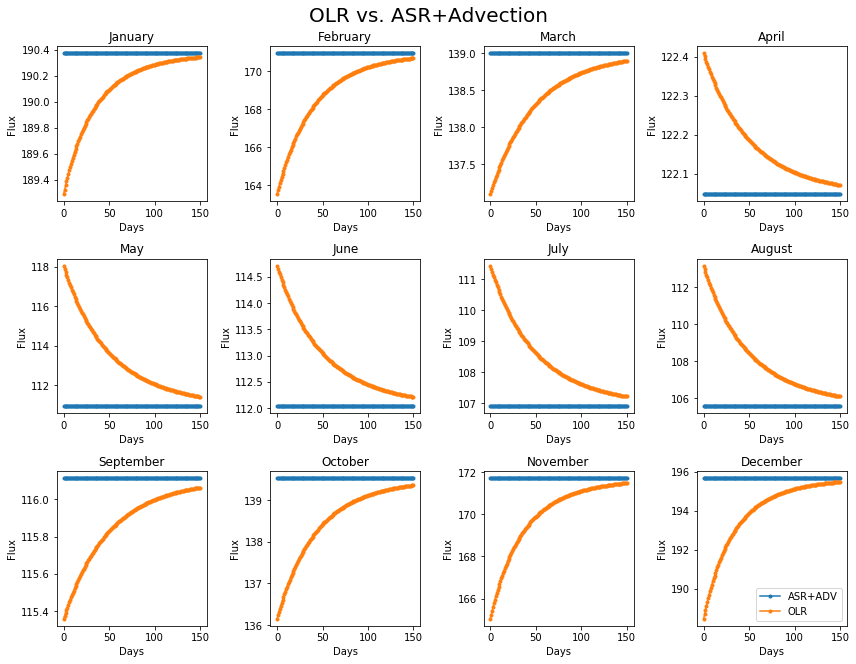

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
axes_list = [item for sublist in axes for item in sublist] 
for month in months:
    ax = axes_list.pop(0)
    y1 = month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['SW_flux_net_clr'][0]+energy_budget_df.loc[month,'rat']['ATM_adv']
    y2 = month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['LW_flux_net_clr'][0]
    x =  month_ds_dict[month].time/ climlab.constants.seconds_per_day
    ax.plot(x, y1, marker = '.', label = 'ASR+ADV')
    ax.plot(x, y2, marker = '.', label = 'OLR')
    ax.set_ylabel('Flux')
    ax.set_xlabel('Days')
    ax.set_title(month)
    plt.tight_layout()
plt.legend()
plt.suptitle('OLR vs. ASR+Advection',fontsize = 20, y = 1.02);

# Fluxes and Heating Rates

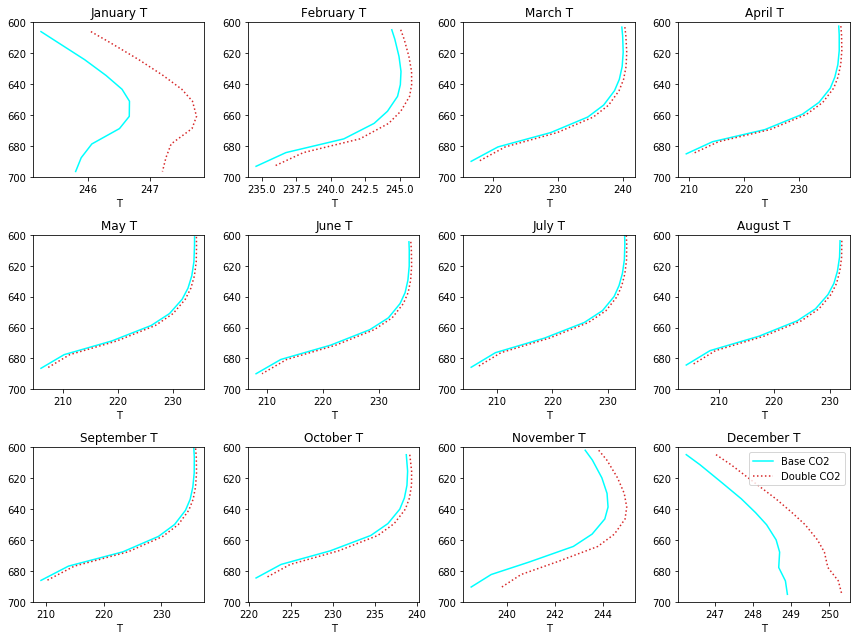

In [12]:
t = times [-1]
ylim = 600
#'advection','turb_hr', 'T', 'LW_flux_net_clr','SW_flux_net_clr'
coords_dict = {'advection':'lev_full', 'turbulent_flux':'lev_full', 'T':'lev_full', 'turb_hr':'lev_full', 'LW_flux_net_clr':'lev_bounds', 'SW_flux_net_clr':'lev_bounds'}
model = month_ds_dict
for output in ['T']:
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
    axes_list = [item for sublist in axes for item in sublist] 
    for idx, month in enumerate(months):
        ax = axes_list.pop(0)
        
        x= month_ds_dict[month].sel(co2_lev = CO2_conc1, model = 'rat', time = t)[output]
        y = month_ds_dict[month].sel(co2_lev = CO2_conc1, model = 'rat', time = t)[coords_dict[output]]
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(x,
                y, 
                color = 'cyan',
                label = 'Base CO2'
               )

        
        
        x = month_ds_dict[month].sel(co2_lev = CO2_conc2, model = 'rat', time = t)[output]
        y = month_ds_dict[month].sel(co2_lev = CO2_conc2, model = 'rat', time = t)[coords_dict[output]]
        
        yidx = y > ylim
        y = y[yidx]
        x = x[yidx]
        
        ax.plot(x,
                y, 
                color = 'C3',
                linestyle = ':',
                label = f'Double CO2'
               )
        
        ax.set_xlabel(output)
        ax.set_ylim([700,ylim])
        ax.set_title(month + ' ' + output)
        plt.tight_layout()
    plt.legend()

# Temperature Difference

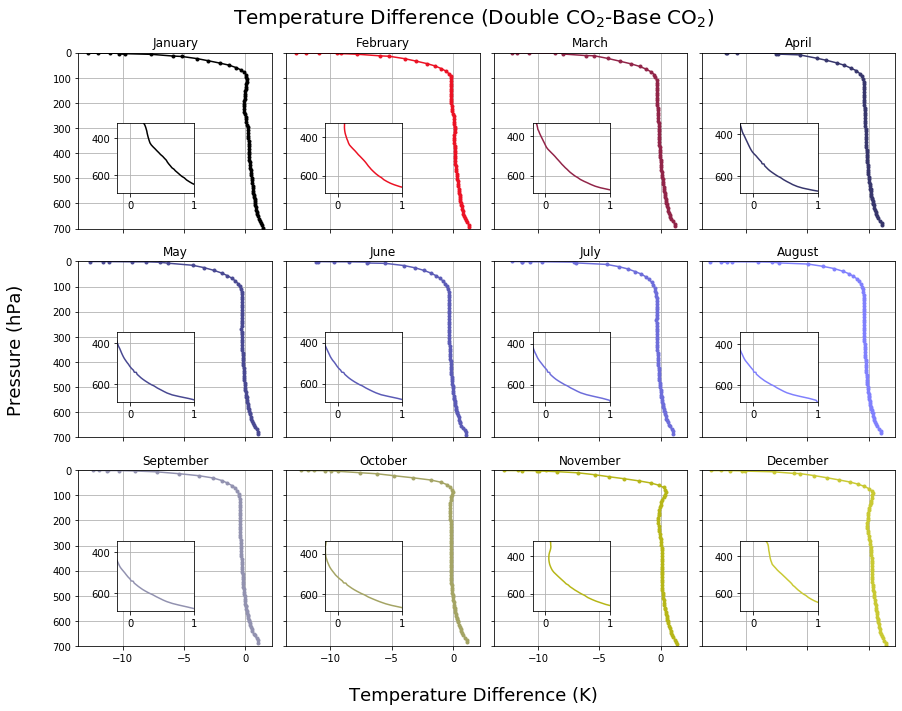

In [26]:
t = times[-1]

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

color = iter(cm.gist_stern(np.linspace(0,1,len(months)+3)))
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,9), sharex = True, sharey = True)
axes_list = [item for sublist in axes for item in sublist] 
for month in months:
    c = next(color)
    ax = axes_list.pop(0)
    x1 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = t)['T']
    x2 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc2, time = t)['T']
    y =  month_ds_dict[month].lev_full
    ax.plot(x2-x1, y, marker = '.', label = 'Temperature', c = c)
    ax.set_title(month)
    ax.set_ylim(700,0)
    ax.grid()
    
    #inset axes
    axins = ax.inset_axes([.2,.2, .4,.4])
    axins.plot((x2-x1)[-40:], y[-40:], c = c)
    axins.set_ylim(y[-40:].max(),y[-40:].min())
    axins.set_xlim(-.2,1.)
    axins.grid()
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    
    
    plt.tight_layout()
fig.text(0.5, -0.04, 'Temperature Difference (K)', ha='center', fontsize = 18)
fig.text(-0.04, 0.5, 'Pressure (hPa)', va='center', rotation='vertical', fontsize = 18)
plt.suptitle(r'Temperature Difference (Double CO$_2$-Base CO$_2$)',fontsize = 20, y = 1.03);
plt.savefig('../figures/temp_dif.png', dpi = 150, bbox_inches = 'tight')

# Greenhouse Effect

In [14]:
(month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])

<xarray.DataArray 'LW_flux_net_clr' (co2_lev: 11)>
array([0.        , 1.18263377, 2.52218072, 3.66222818, 4.01602572,
       3.92333183, 3.6092039 , 3.14405755, 2.42949823, 2.07755542,
       1.44373952])
Coordinates:
    model       <U3 'rat'
  * co2_lev     (co2_lev) float64 0.0 1e-06 5e-06 2e-05 ... 0.00076 0.001 0.0015
    time        int64 0
    lev_bounds  float64 0.3419

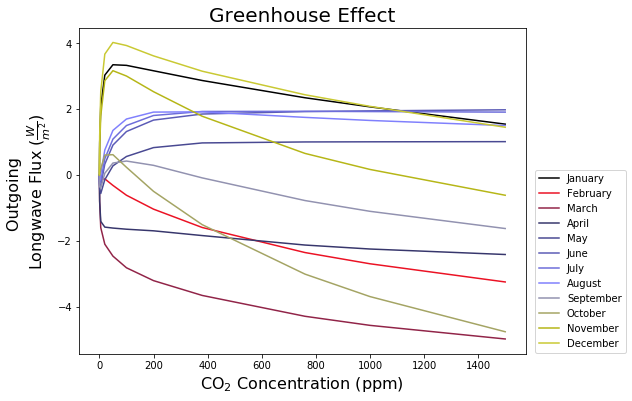

In [24]:
fig, ax = plt.subplots(figsize = (8,6))
color = iter(cm.gist_stern(np.linspace(0,1,len(months)+3)))
for month in months:
    x = month_ds_dict[month].co2_lev *1e6
    y = (month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])
    plt.plot(x, y,
            label = month, 
             color = next(color))
plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
plt.ylabel('Outgoing \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)
plt.title('Greenhouse Effect', fontsize = 20)
plt.legend(bbox_to_anchor = [1.01, 0.58]);
plt.savefig('../figures/GHE.png', dpi = 150, bbox_inches = 'tight')

# Surface CO2 Effect

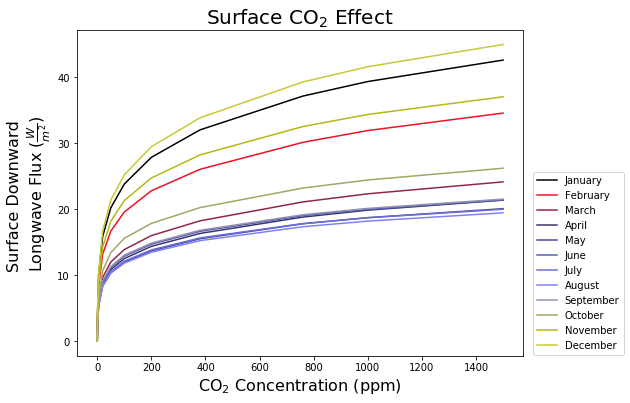

In [25]:
fig, ax = plt.subplots(figsize = (8,6))
color = iter(cm.gist_stern(np.linspace(0,1,len(months)+3)))
for month in months:
    x = month_ds_dict[month].co2_lev *1e6
    y = (month_ds_dict[month].sel(time = times[-1], model = 'rat').isel(lev_bounds = -1)['LW_flux_down_clr'] -
         month_ds_dict[month].sel(time = times[-1], model = 'rat', co2_lev = 0).isel(lev_bounds = -1)['LW_flux_down_clr'])
    plt.plot(x,y,
        label = month, 
        color = next(color))
plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
plt.ylabel('Surface Downward \n' r'Longwave Flux ($\frac{W}{m^2}$)', fontsize = 16)
plt.title('Surface CO$_2$ Effect', fontsize = 20)
plt.legend(bbox_to_anchor = [1.01, 0.58]);
plt.savefig('../figures/sfc_CO2_effect.png', dpi = 150, bbox_inches = 'tight')

#### absorption coefficients and pressure

In [17]:
# estimate the absorption coefficient for CO2 = 1e-4 m2/kg
# P*CO2 mixing ratio * absorption coefficient / g = 1
# so g/CO2 mixing ratio /absorption coefficient = P

g = 9.8 #m/s2
mmr = 200*1e-6#ppm
abs_coef = 1

P = g/(mmr*abs_coef) #kg*s2/ m
P/100

490.00000000000006

In [18]:
wl = 15 #um
wn = 1/wl * 1e4
wn

666.6666666666666

#### standard atmosphere vs antarctic

In [19]:
#### compare between our antarctic version and a normal atmosphere
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)


Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


NameError: name 'results_dict' is not defined

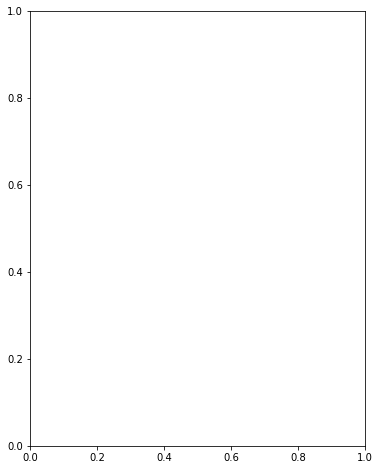

In [21]:
fig, ax = plt.subplots(figsize = [6,8])
colors=cm.twilight(np.linspace(0,1,8))
for month in ['March']:
    #plot our antarctic atmosphere
    x = np.asarray(results_dict[0]['Tatm'][0.00038][month])
    y = results_dict[0]['lev'][0.00038][month]
    plt.plot(x, y, c = colors[1], lw = 4)
    
    #plot standard atmosphere
    plt.plot(rcm.state['Tatm'], rcm.lev, c= colors[5], lw = 4)
    
    #labels and lims
    plt.ylabel('Pressure (hPa)', fontsize = 20)
    plt.xlabel('Temperature (K)', fontsize = 20)
    plt.ylim([750,-50])
plt.grid()
plt.savefig('../figures/stp_antarctic_comp.png', dpi = 150, bbox_inches = 'tight')

In [22]:
for month in months:
    for co2 in co2_lev:
        for time in np.arange(0,((steps+1)*timestep),timestep):
            for model in model_dict.keys():
                
                #TOA Frad
                month_ds_dict[month]['F_rad_toa'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) #W/m2

                #Surface Frad
                month_ds_dict[month]['F_rad_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                #Surface Fturb
                month_ds_dict[month]['F_turb_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['turbulent_flux'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                month_ds_dict[month]['F_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = model_dict[model][F_rad_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)] - model_dict[model][F_turb_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)]
                #dT/dt
                month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)) - 
                                np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)))[:-1]/np.asarray(timestep)) #K/s

                #dz
                month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.diff(month_ds_dict[month]['z_bounds']) #surface to atmosphere #m

                #heat capacity (density*cp)
                month_ds_dict[month]['R'] = 8.314 #J/mol/K
                month_ds_dict[month]['MW_air'] = 0.0289647 #kg/mol
                month_ds_dict[month]['pressure_TOA'] = 100*month_ds_dict[month]['lev'][-1] #pascal (kg/m/s2)
                month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = (month_ds_dict[month]['MW_air']*100*month_ds_dict[month]['lev'])/(np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['R']) #kg/m^3
                month_ds_dict[month]['cp_air'] = 1003 #specific heat of air (at 250 K) J/(kg*K)
                month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)]*month_ds_dict[month]['cp_air']

                #atmospheric heat content rate at each level
                month_ds_dict[month]['total_atm_heat_content_rate'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2

                #advective flux at each level
                month_ds_dict[month]['total_adv_flux'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['advection'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2
                
                

NameError: name 'co2_lev' is not defined